<a href="https://www.kaggle.com/code/ayushmaria/nlp-disaster-tweets?scriptVersionId=102444215" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# This Notebook is my first attempt at understanding NLP and expand my knowledge. 
## Please feel free to comment for any doubts or improvement advice.

In [1]:
!pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 961.5 kB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import SnowballStemmer
from collections import Counter
from num2words import num2words
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")

In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [5]:
print(train.shape)

(7613, 5)


In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# In order to proceed further I will perform some EDA to understand the data.

<AxesSubplot:xlabel='target', ylabel='count'>

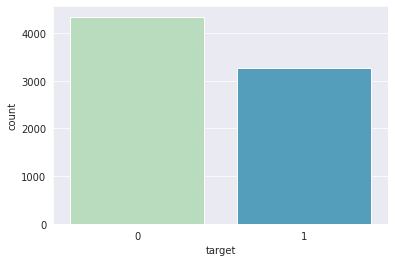

In [7]:
sns.set_style('darkgrid')
sns.countplot(x=train['target'],palette='GnBu')

The following is the meaning of the target labels:
* 0: Non Disaster
* 1: Disaster

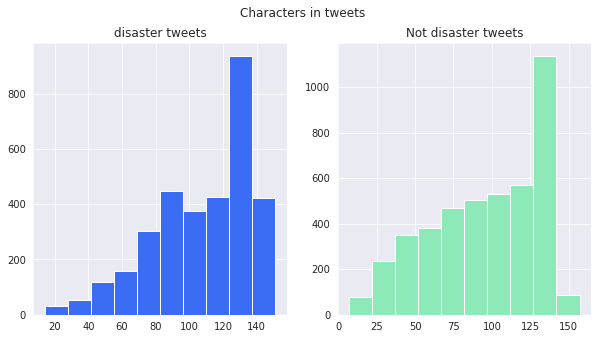

In [8]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
disaster_tweet=train[train['target']==1]['text'].str.len()
ax[0].hist(disaster_tweet,color='#3b6df4')
ax[0].set_title('disaster tweets')
notdisaster_tweet=train[train['target']==0]['text'].str.len()
ax[1].hist(notdisaster_tweet,color='#8de9b8')
ax[1].set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

In [9]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [10]:
train['location'].value_counts().head(n=20)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: location, dtype: int64

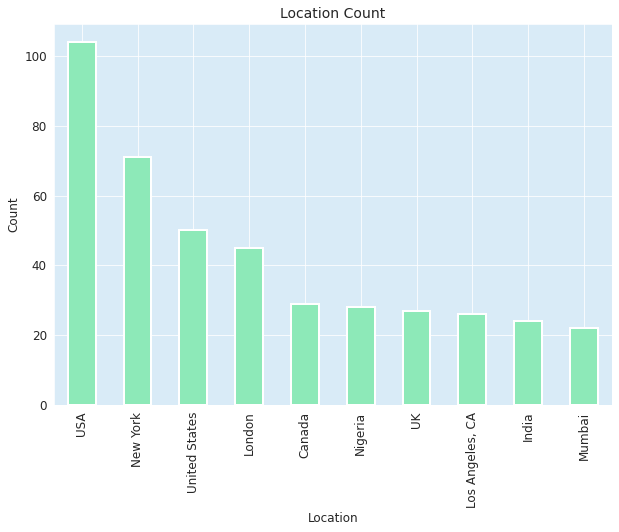

In [11]:
plt.figure(figsize = (10, 7))
ax = plt.axes()
ax.set_facecolor('#d9ebf7')
ax = ((train.location.value_counts())[:10]).plot(kind = 'bar', color = '#8de9b8', linewidth = 2)
plt.title('Location Count', fontsize = 14)
plt.xlabel('Location', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
ax.xaxis.set_tick_params(labelsize = 12, rotation = 90)
ax.yaxis.set_tick_params(labelsize = 12)

<AxesSubplot:>

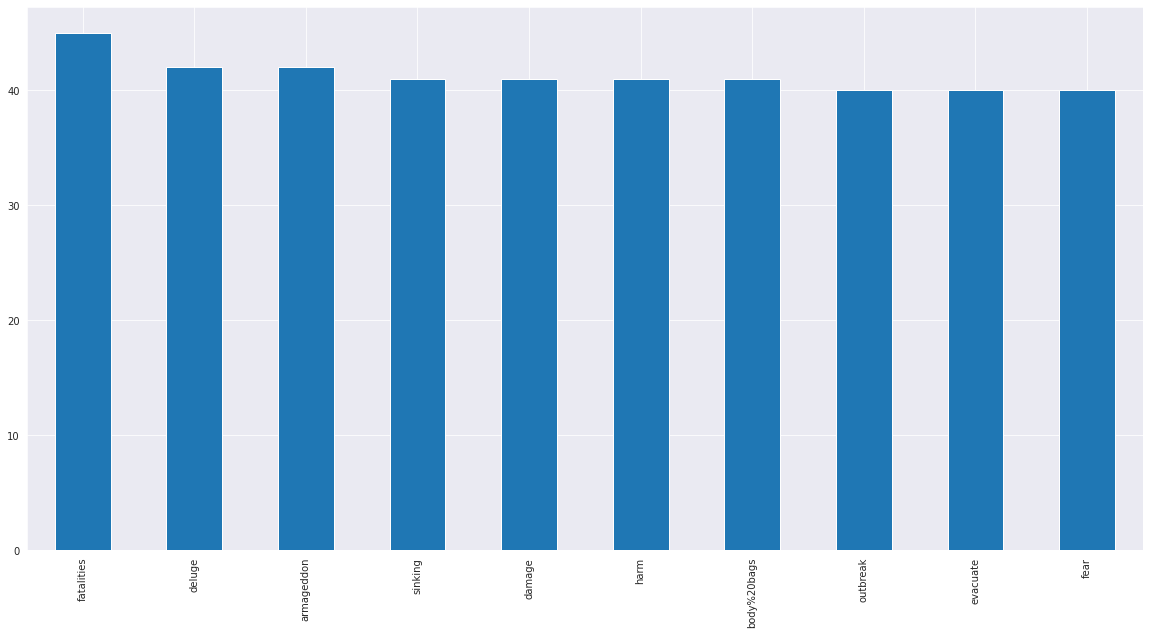

In [12]:
train['keyword'].value_counts().head(10).plot(kind='bar',figsize= (20,10))

# Text Cleaning

It is a good practice to remove noise from text data for NLP. Some examples of noise can be:
* URL 
* Emoticons
* Tags
* Punctuation Marks
* Stop Words
* Stemming

In [13]:
# Some basic helper functions to clean text by removing urls, emojis, html tags, punctuations and Stop Words.

def remove_URL(data):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', data)


def remove_emoji(data):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', data)


def remove_html(data):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', data)


def remove_punct(data):
    table = str.maketrans('', '', string.punctuation)
    return data.translate(table)

stop = stopwords.words('english')
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

In [14]:
# Applying helper functions on Train Dataset

train['text_clean'] = train['text'].apply(lambda x: remove_URL(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_emoji(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_html(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_punct(x))
train['text_clean'] = train['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [15]:
train['text_clean'] = train['text_clean'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))

In [16]:
train

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all resid ask shelter place notifi offic no ev...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo rubi alaska smoke wildfir ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrari thetawniest the control wild fire c...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,polic investig ebik collid car littl portug eb...


In [17]:
test['text_clean'] = test['text'].apply(lambda x: remove_URL(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_emoji(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_html(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_punct(x))
test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))

In [18]:
test

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,just happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquak safeti lo angel ûò safeti fasten xrwn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri wors last hurrican my city3oth hardes...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derail chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issu hazard weather outlook hwo


# Training LSTM Model

In [19]:
df_train = train.drop(['id','keyword','location','text'],axis=1)
df_test = test.drop(['keyword','location','text'],axis=1)

In [20]:
# Move texts and targets from train & test dataset to the list:
training_message = []
testing_message = []
training_labels = []
for i in range(len(df_train)):
    training_message.append(df_train.loc[i,'text_clean'])
    training_labels.append(df_train.loc[i,'target'])
    
for i in range(len(df_test)):
    testing_message.append(df_test.loc[i,'text_clean'])

In [21]:
vocab_size = 23000
embedding_dim = 32
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [22]:
# Tokenization Process:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_message)
word_index = tokenizer.word_index

In [23]:
# texts_to_sequences Process:
training_message = tokenizer.texts_to_sequences(training_message)
testing_message = tokenizer.texts_to_sequences(testing_message)

In [24]:
#pad_sequences Process:
training_padded = pad_sequences(training_message,maxlen=max_length, truncating=trunc_type, padding=padding_type)
testing_padded = pad_sequences(testing_message,maxlen=max_length, truncating=trunc_type, padding=padding_type)

In [25]:
training_padded = np.array(training_padded)
testing_padded = np.array(testing_padded)
training_labels = np.array(training_labels)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='Adamax',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

2022-08-03 16:16:18.142521: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           736000    
_________________________________________________________________
bidirectional (Bidirectional (None, 24)                4320      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 740,345
Trainable params: 740,345
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(
    training_padded, 
    training_labels, 
    epochs = 50, 
    batch_size = 64,  
    validation_split=0.2
)

2022-08-03 16:16:19.018696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
96/96 [==============================] - 25s 189ms/step - loss: 0.6797 - accuracy: 0.5782 - precision: 0.1111 - recall: 3.9032e-04 - val_loss: 0.6857 - val_accuracy: 0.5345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
96/96 [==============================] - 14s 150ms/step - loss: 0.6573 - accuracy: 0.5831 - precision: 1.0000 - recall: 0.0090 - val_loss: 0.6598 - val_accuracy: 0.5378 - val_precision: 1.0000 - val_recall: 0.0071
Epoch 3/50
96/96 [==============================] - 15s 159ms/step - loss: 0.6034 - accuracy: 0.6849 - precision: 0.9075 - recall: 0.2795 - val_loss: 0.6112 - val_accuracy: 0.6750 - val_precision: 0.9084 - val_recall: 0.3357
Epoch 4/50
96/96 [==============================] - 14s 146ms/step - loss: 0.5339 - accuracy: 0.7698 - precision: 0.8404 - recall: 0.5589 - val_loss: 0.5519 - val_accuracy: 0.7505 - val_precision: 0.8664 - val_recall: 0.5487
Epoch 5/50
96/96 [==============================] - 14s 143ms/step - loss: 0.4735 - accu

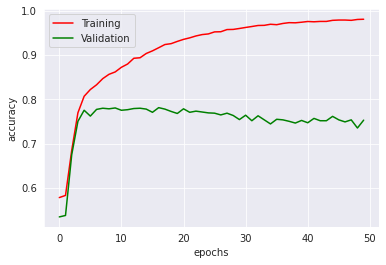

In [28]:
plt.plot(history.history["accuracy"], color="r")
plt.plot(history.history["val_accuracy"], color="g")
plt.legend(["Training", "Validation"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

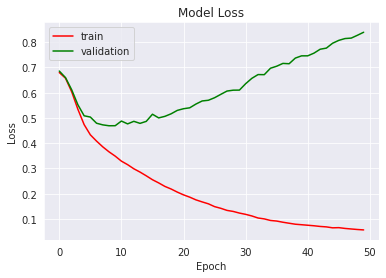

In [29]:
plt.plot(history.history["loss"], color="r")
plt.plot(history.history["val_loss"], color="g")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

In [30]:
test_predict = model.predict(testing_padded).round().astype(int)

# Submission

In [31]:
submission = pd.DataFrame({'id':df_test['id'],'target':test_predict.ravel()})
submission.to_csv('submission.csv',index=False)

# I willl further use BERT and GloVe and compare them to the output of the LSTM. I do realize that the LSTM requires more tuning and am open to suggestions.

## I also have to perform the following:
* Remove Stopwords
* Stemming
* Lemmatisation
* TF-IDF (Feature Engineering)

TF - IDF

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(min_df=.005, max_df=.9, ngram_range=(1,2), tokenizer=lambda doc: doc, lowercase=False)
cvec.fit(train['text_clean'])

CountVectorizer(lowercase=False, max_df=0.9, min_df=0.005, ngram_range=(1, 2),
                tokenizer=<function <lambda> at 0x7f8b6d568ef0>)

In [33]:
cvec_counts = cvec.transform(train['text_clean'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (7613, 537)
nonzero count: 460127
sparsity: 11.26%


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<7613x537 sparse matrix of type '<class 'numpy.float64'>'
	with 460127 stored elements in Compressed Sparse Row format>

In [35]:
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()
tfidf = pd.DataFrame(transformed_weights, columns=vocab)
tfidf['Keyword'] = tfidf.idxmax(axis=1)
tfidf['Max'] = tfidf.max(axis=1)
tfidf['Sum'] = tfidf.drop('Max', axis=1).sum(axis=1)
tfidf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,÷,û,û,û ª,û ï,û ò,û ÷,Keyword,Max,Sum
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h q,0.293799,7.021258
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s k,0.306038,6.108985
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,l t,0.252486,7.356700
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.351569,6.830693
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s,0.225324,7.388584
5,0.0,0.0,0.108383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,i r,0.364067,7.426578
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,f l,0.398555,7.243777
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e,0.243792,5.530275
8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a c,0.258617,6.712198
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a f,0.289851,5.183748


In [36]:
train_1 = train.drop(['id', 'keyword','location'], axis=1)
tfidf_new = pd.merge(train_1, tfidf, left_index=True, right_index=True)
tfidf_new

,text,target,text_clean,0,1,2,3,4,5,6,...,÷,û,û,û ª,û ï,û ò,û ÷,Keyword,Max,Sum
0,Our Deeds are the Reason of this #earthquake M...,1,our deed reason earthquak may allah forgiv us,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h q,0.293799,7.021258
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s k,0.306038,6.108985
2,All residents asked to 'shelter in place' are ...,1,all resid ask shelter place notifi offic no ev...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,l t,0.252486,7.356700
3,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.351569,6.830693
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo rubi alaska smoke wildfir ...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s,0.225324,7.388584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,d g,0.245779,6.561666
7609,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrari thetawniest the control wild fire c...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h e,0.212806,7.987584
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s volcano hawaii,0.221641,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.377796,5.551405
7611,Police investigating after an e-bike collided ...,1,polic investig ebik collid car littl portug eb...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e b,0.244155,8.206206
